In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union

def compute_voronoi(points, boundary_points):
    """
    Compute Voronoi diagram for given points.
    """
    return Voronoi(points)

def compute_centroids(vor, points, bounding_polygon, obstacles):
    """
    Compute centroids of the Voronoi cells that do not intersect with obstacles.
    Keep original points for cells that do intersect or go outside the bounding polygon.
    """
    new_points = []
    for point, region_index in zip(points, vor.point_region):
        region = vor.regions[region_index]
        if not region or -1 in region:
            new_points.append(point)  # Keep original point for infinite regions
            continue
        
        # Create a polygon for the Voronoi cell
        region_vertices = [vor.vertices[i] for i in region]
        cell_polygon = Polygon(region_vertices)
        
        # If the region intersects with any obstacle, keep the original point
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            new_points.append(point)
        else:
            # Calculate the centroid of the cell
            if cell_polygon.is_valid and not cell_polygon.is_empty:
                centroid = cell_polygon.centroid
                # Ensure the centroid is inside the bounding polygon
                if bounding_polygon.contains(centroid):
                    new_points.append(centroid.coords[0])
                else:
                    # If centroid is outside, keep the original point
                    # Alternatively, you could project it back onto the bounding polygon boundary
                    closest_point = bounding_polygon.exterior.interpolate(bounding_polygon.exterior.project(centroid))
                    new_points.append(closest_point.coords[0])
            else:
                new_points.append(point)  # Fallback to original point if invalid
    
    return np.array(new_points)


# Generate random initial points (Voronoi sites)
np.random.seed(42)

# Define bounding polygon (a rectangular boundary)
bounding_polygon = Polygon([(0, 0), (0, 100), (100, 100), (100, 0)])

# Define obstacles (rectangular polygons for simplicity)
obstacles = [
    Polygon([(20, 20), (20, 40), (40, 40), (40, 20)]),  # Obstacle 1
    Polygon([(60, 60), (60, 80), (80, 80), (80, 60)]),  # Obstacle 2
]

# Sample initial points
desired_points = 1000
points = []
while len(points) < desired_points:
    x = np.random.rand()*100
    y = np.random.rand()*100
    point = Point(x, y)
    while any(point.intersects(obs) for obs in obstacles):
        x = np.random.rand()*100
        y = np.random.rand()*100
        point = Point(x, y)
    points.append((x, y))

init_points = np.array(points)

# Obtain boundary points from obstacles
def _split_edge(edge, segment_length):
    """Split a LineString edge into segments of specified length."""
    pts = []

    num_segments = int(edge.length // segment_length)
    if edge.length % segment_length != 0:
        num_segments += 1
    # Create each segment
    for i in range(num_segments):
        pts.append(np.array(edge.interpolate(i * segment_length).xy).reshape(2))

    return pts

def geom_segment(geometry, segment_length):
    all_pts = []

    # Extract and split each edge of the polygon
    for i in range(len(geometry.exterior.coords) - 1):
        # Each edge of the polygon as a LineString
        edge = LineString([geometry.exterior.coords[i], geometry.exterior.coords[i + 1]])
        pts = _split_edge(edge, segment_length)
        all_pts.extend(pts)          

    idx = np.arange(len(all_pts))

    segs = np.stack([idx, idx+1], axis=1) % len(all_pts)
    return np.array(all_pts), segs

boundary_point_gap = 3
boundary_points = []
for obs in obstacles:
    points, segs = geom_segment(obs, boundary_point_gap)
    boundary_points.append(points)

points, segs = geom_segment(bounding_polygon, boundary_point_gap)
boundary_points.append(points)
boundary_points = np.concat(boundary_points)

# Perform Centroidal Voronoi Tessellation
points = np.concat([init_points, boundary_points])
iterations = 500
for i in range(iterations):
    # Compute Voronoi diagram
    voronoi = Voronoi(points)
    
    # Compute centroids of the Voronoi cells not intersecting with obstacles, constrained to the bounding polygon
    points = compute_centroids(voronoi, points, bounding_polygon, obstacles)

voronoi = Voronoi(points)


In [78]:
import numpy as np
import cvxpy as cp
from shapely.affinity import affine_transform
from shapely.geometry import Polygon
from shapely.geometry.polygon import orient
import matplotlib.pyplot as plt

def get_polygon_inequalities(polygon: Polygon):
    """
    Computes the inequality constraints (Ax ≤ b) for a convex polygon.
    Returns:
        A: (m, d) array of normal vectors for each edge.
        b: (m, ) array of constraint bounds.
    """

    # Beware the vertices are in counter-clockwise order
    vertices = np.array(polygon.exterior.coords[:-1])  # Remove duplicate last point
    next_vertices = np.array(polygon.exterior.coords[1:])  # Next vertices for each edge

    mid_points = (vertices + next_vertices) / 2  # Midpoints of each edge

    edges = np.diff(vertices, axis=0, append=vertices[:1])  # Ensure all edges
    
    # Compute inward normal 
    normals = np.column_stack([-edges[:, 1], edges[:, 0]])  
    normals =  -normals / np.linalg.norm(normals, axis=1, keepdims=True)  # Normalize

    # Compute b = a_i^T v_i
    b = np.einsum('ij,ij->i', normals, mid_points)  
    return normals, b
def get_normalized_polygon(polygon: Polygon, scale=10):
    """
    Normalize a polygon to the unit circle.
    """
    polygon = orient(polygon, sign=1.0)  # Ensure counter-clockwise orientation
    centroid = np.array(polygon.centroid.xy)
    bounds = np.array(polygon.bounds)
    x_scale = bounds[2] - bounds[0] 
    y_scale = bounds[3] - bounds[1] 
    transform_matrix = np.array((scale / x_scale, scale / y_scale))
    offset = np.array([-centroid[0]* scale/x_scale , -centroid[1] * scale/y_scale])
    return affine_transform(polygon, [scale /x_scale, 0, 0, scale/y_scale, offset[0], offset[1]]), transform_matrix, offset, scale
def johns_ellipsoid_edge_constraints(polygon: Polygon):
    """
    Computes John's Ellipsoid (largest inscribed ellipsoid) for a convex polygon using CVXPY
    with polygon edge constraints instead of vertex constraints.
    """
    
    normalized_polygon, transform_matrix, offset, scale = get_normalized_polygon(polygon)
    A, b = get_polygon_inequalities(normalized_polygon)  # Compute polygon inequalities
    dim = A.shape[1]  # Dimension (should be 2 for 2D)

    # Define optimization variables
    B = cp.Variable((dim, dim), symmetric=True)  
    
    d = cp.Variable((dim,))  # Center of the ellipsoid

    # Ensure P is positive definite
    constraints = [ B >> 1e-3 * np.eye(dim)]

    # Edge constraints: max_{x ∈ E} a_i^T x ≤ b_i
    for i in range(A.shape[0]):
        constraints.append(cp.norm(B @ A[i].T, 2) <= b[i] - A[i].T @ d) 

    # log det (B^-1) = -log det (B)
    obj = cp.Maximize(cp.log_det(B))

    # Solve the convex optimization problem
    prob = cp.Problem(obj, constraints)
    prob.solve()

    if prob.status in ["optimal", "optimal_inaccurate"]:
        # Transform the ellipsoid back to the original space
        t = np.diag(1/transform_matrix)
        return t@B.value, -t@(offset.squeeze() - d.value)

    else:
        print(prob.status)
        return None, None
        raise ValueError("Optimization failed.")
def plot_ellipsoid(ax, A, c):
    """
    Plot the ellipsoid defined by the shape matrix A and center c.
    """
    A = (A + A.T) / 2
    t = np.linspace(0, 2*np.pi, 100)
    circle = np.array([np.cos(t), np.sin(t)])
    U, S, _ = np.linalg.svd(A)
    L = np.diag(S) 
    ellipse = U @ L@ circle + c[:, None]
    ax.plot(ellipse[0], ellipse[1], 'gray', lw=2)


1193


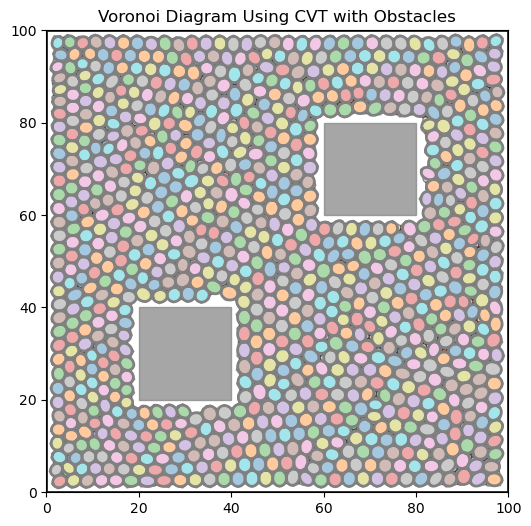

In [81]:
def plot_voronoi(voronoi, bounding_polygon, obstacles):
    """
    Plot Voronoi diagram with obstacles.
    """
    plt.figure(figsize=(8, 6))
    ax = plt.gca()
    print(len(voronoi.regions))
    # Plot Voronoi cells
    for region_index in voronoi.regions:
        if not region_index or -1 in region_index:
            continue  # Skip infinite regions
        
        region = [voronoi.vertices[i] for i in region_index]
        cell_polygon = Polygon(region)
        
        # Skip regions that intersect with any obstacle
        if any(cell_polygon.intersects(obs) for obs in obstacles):
            continue
        
        # Plot the Voronoi cell
        if cell_polygon.is_valid and not cell_polygon.is_empty:
            x, y = cell_polygon.exterior.xy
            plt.fill(x, y, alpha=0.4, edgecolor='k')

            A_matrix, c = johns_ellipsoid_edge_constraints(cell_polygon)
            plot_ellipsoid(ax, A_matrix, c)
            

    # Plot Voronoi sites
    # plt.plot(voronoi.points[:, 0], voronoi.points[:, 1], 'ro')

    # Plot bounding polygon
    x, y = bounding_polygon.exterior.xy
    plt.plot(x, y, 'b-', lw=2)

    # Plot obstacles
    for obs in obstacles:
        x, y = obs.exterior.xy
        plt.fill(x, y, color='gray', alpha=0.7)

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title("Voronoi Diagram Using CVT with Obstacles")
    plt.show()
plot_voronoi(voronoi, bounding_polygon, obstacles)

## Verify Ellipsoid to Gaussian

Mean (mu): [1.30659375e-15 9.19017063e-15]
Covariance Matrix (Sigma):
 [[0.81783007 0.7009972 ]
 [0.7009972  4.35619689]]


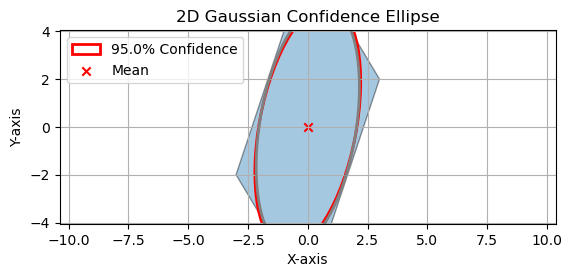

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

def ellipsoid_to_gaussian(A, b, p):
    """
    Convert an ellipsoid equation x^T A x + b^T x + c = 0
    to a 2D Gaussian distribution with mean and covariance.
    
    Parameters:
    A (numpy.ndarray): 2x2 symmetric positive definite matrix defining the ellipsoid shape.
    b (numpy.ndarray): 2x1 vector defining the ellipsoid center shift.
    p (float): Confidence level (e.g., 0.95 for 95% confidence).
    
    Returns:
    mu (numpy.ndarray): Mean of the Gaussian.
    Sigma (numpy.ndarray): Covariance matrix of the Gaussian.
    """
    # Compute mean
    mu = b
    
    # Compute chi-squared value for the given confidence level
    chi2_val = chi2.ppf(p, df=2)
    
    # Compute covariance matrix
    Sigma = A.T@A /chi2_val
    
    return mu, Sigma

def plot_gaussian_ellipse(mu, Sigma, p, ax=None):
    """
    Plot the confidence ellipse of a 2D Gaussian distribution.
    
    Parameters:
    mu (numpy.ndarray): Mean of the Gaussian.
    Sigma (numpy.ndarray): Covariance matrix.
    p (float): Confidence level.
    ax (matplotlib.axes._subplots.AxesSubplot, optional): Matplotlib axis.
    """
    if ax is None:
        fig, ax = plt.subplots()
    
    # Compute eigenvalues and eigenvectors of covariance matrix
    eigvals, eigvecs = np.linalg.eigh(Sigma)
    
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    # Compute the angle of the ellipse
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    
    # Compute the width and height of the ellipse (scaled by chi2 value)
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(p, df=2))
    
    # Plot ellipse
    ellipse = Ellipse(mu, width, height, angle=angle, edgecolor='r',
                                             facecolor='none', linewidth=2, label=f'{p*100:.1f}% Confidence')
    ax.add_patch(ellipse)
    ax.scatter(*mu, color='red', marker='x', label='Mean')
    
    # Set axis limits
    ax.set_xlim(mu[0] - width, mu[0] + width)
    ax.set_ylim(mu[1] - height, mu[1] + height)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.legend()
    ax.set_title("2D Gaussian Confidence Ellipse")
    plt.grid()
    plt.show()

# Example usage
p = 0.95                        # 95% confidence level

polygon = Polygon([(-3, -2), (0, -7), (3, 2), (0, 7) ])
A, b = johns_ellipsoid_edge_constraints(polygon)

mu, Sigma = ellipsoid_to_gaussian(A, b, p)
print("Mean (mu):", mu)
print("Covariance Matrix (Sigma):\n", Sigma)

# Plot the confidence ellipse

x, y = polygon.exterior.xy
plt.fill(x, y, alpha=0.4, edgecolor='k')
ax = plt.gca()
ax.set_aspect("equal")
plot_ellipsoid(ax, A, b)
plot_gaussian_ellipse(mu, Sigma, p, ax)
